In [4]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

train_gpu = torch.cuda.is_available()

if train_gpu:
  print("[+] Running on CUDA enabled GPU")
else:
  print("[+] Running on CPU") 

[+] Running on CUDA enabled GPU


In [5]:
# Subprocesses for data loading
num_workers = 10

# Batch size
batch_size = 32

# Ratio of samples for validation set
valid_size = 0.2

# Defining transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

# Separate out validation set sample indices
num_train = len(train_data)
index_iter = list(range(num_train))
np.random.shuffle(index_iter)
split = int(np.floor(num_train * valid_size))
train_idx, valid_idx = index_iter[split:], index_iter[:split]

# Obtain Sampler for getting train and validation samples
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Use Sampler to generate loader for train, validation, test data
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Define image classes/labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
           'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


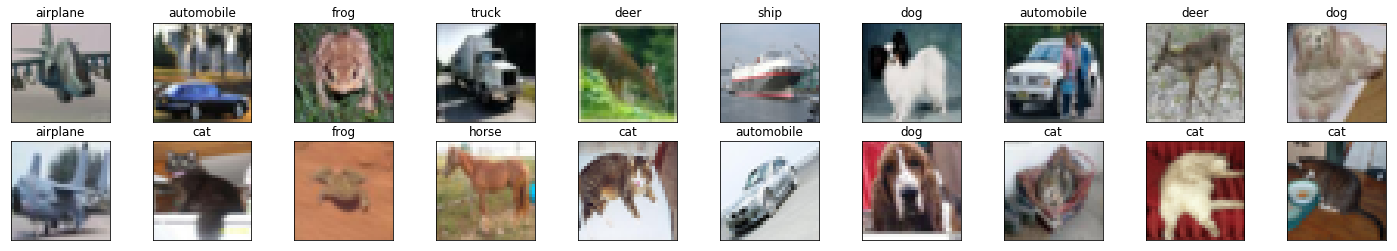

In [6]:
"""
    VISUALIZE DATASET IMAGES WITH LABELS
"""

import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

images, labels = next(iter(train_loader))
images = images.numpy() # Convert images to numpy for display

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

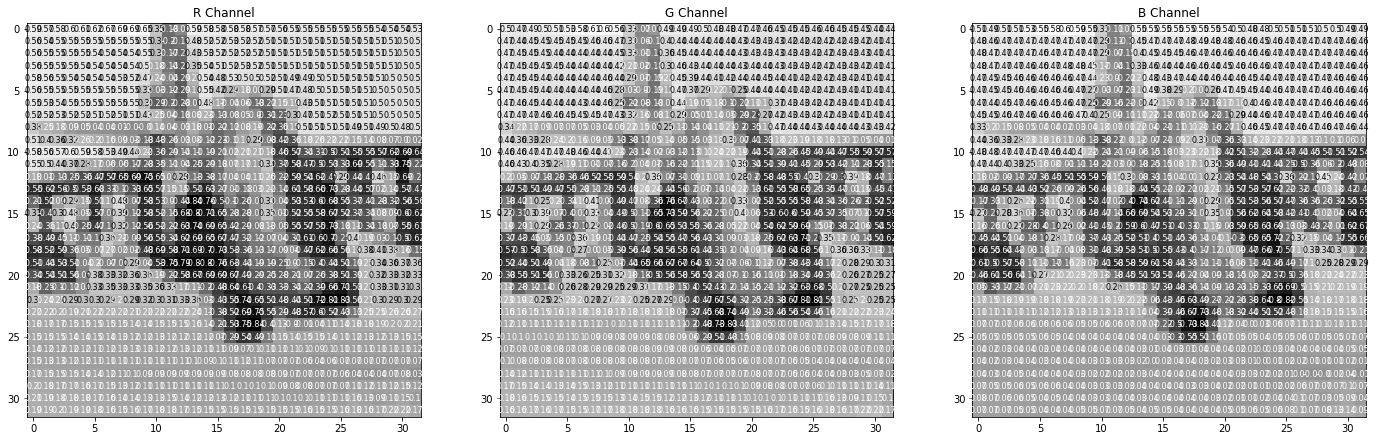

In [7]:
"""
    VISUALIZE IMAGES WITH PIXEL LEVEL DETAIL
"""

rgb_img = np.squeeze(images[0])
channels = ['R Channel', 'G Channel', 'B Channel']

fig = plt.figure(figsize = (24, 24))

for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
  """
    Defining a Convolutional Neural Network with specified layers
    
    Architecture
    ============
    
    Input --> conv1 --> conv2 --> maxpool --> conv3 --> maxpool --> fc1 --> fc2
    
    Input
    =====
            
    32 x 32 x 3 images    
    
  """
  
  def __init__(self):
    
    super(CNN, self).__init__()
    
    # Convolutional Layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 25, 3, padding=1)
    self.conv3 = nn.Conv2d(25, 32, 3, padding=1)
    self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv5 = nn.Conv2d(64, 75, 3, padding=1)
    self.conv6 = nn.Conv2d(75, 128, 3, padding=1)
    
    # MaxPool Layers
    self.pool = nn.MaxPool2d(2, 2)
    
    # Fully Connected Layers
    self.fc1 = nn.Linear(8 * 8 * 128, 2000)
    self.fc2 = nn.Linear(2000, 10)
    
    # Dropout Layer
    self.dropout = nn.Dropout(p=0.2)
  
    # Batch Normalization
    self.bn1 = nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.1,
                                    affine=True, track_running_stats=True)
    self.bn2 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1,
                                    affine=True, track_running_stats=True)
    self.bn3 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1,
                                    affine=True, track_running_stats=True)
    self.bn4 = nn.BatchNorm2d(num_features=75, eps=1e-05, momentum=0.1,
                                    affine=True, track_running_stats=True)
    self.bn5 = nn.BatchNorm2d(num_features=128, eps=1e-05, momentum=0.1,
                                    affine=True, track_running_stats=True)
    
  def forward(self, x):
    
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.bn1(x)
    
    x = self.pool(self.bn2(F.relu(self.conv3(x))))
    
    x = F.relu(self.conv4(x))
    x = self.bn3(x)
    x = self.pool(self.bn4(F.relu(self.conv5(x))))
    
    x = F.relu(self.conv6(x))
    x = self.bn5(x)
    
    # Flatten image
    x = x.view(-1, 128 * 8 * 8)
    
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    
    x = self.dropout(x)
    x = self.fc2(x)
    
    return x

In [9]:
model = CNN()
print("[+]                  MODEL ARCHITECTURE                 ")
print(model)

if train_gpu:
  model.cuda()

[+]                  MODEL ARCHITECTURE                 
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(25, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(75, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
  (bn1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [0]:
import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define hyperparameters
lr = 1e-2
lr_decay = 1e-3
momentum = 0.0035
# Defie optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [11]:
def correct(output, groundTruth):
  assert groundTruth.size(0) == output.size(0)
  _, indices = torch.max(output, 1)
  ch=torch.eq(groundTruth,indices)
  return torch.sum(ch).item()


epochs = 50

min_validation_loss = np.Inf


for epoch in range(1, epochs+1):
  
  train_loss = 0
  valid_loss = 0
  train_accuracy = 0
  
  # Move model to train mode
  model.train()
  
  for inputs, labels in train_loader:
    
    if train_gpu:
      inputs, labels = inputs.cuda(), labels.cuda()
      
    # Clear gradients
    optimizer.zero_grad()
    
    # Forward pass
    output = model(inputs)
    
    # Compute loss
    loss = criterion(output, labels)
    
    # Compute correct labels
    train_accuracy += correct(output, labels)
    
    # Backpropagation
    loss.backward()
    
    # Update weights 
    optimizer.step()
    
    # Accumulate loss
    train_loss += loss.item()*inputs.size(0)

  # Test on validation set
  
  # Move model to evaluation mode
  model.eval()
  
  for inputs, labels in valid_loader:
    
    if train_gpu:
      inputs,labels = inputs.cuda(), labels.cuda()
      
    output = model(inputs)
    loss = criterion(output, labels)
    valid_loss += loss.item() * inputs.size(0)
    
  # Calculate Avg loss
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
  
  train_accuracy = train_accuracy/len(train_loader.sampler)
  
  print('Epoch: {} \tAccuracy: {:.2f} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_accuracy*100, train_loss, valid_loss))

  # Save if best possible model found
  if valid_loss <= min_validation_loss:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      min_validation_loss, valid_loss))
      torch.save(model.state_dict(), 'model_cifar.pt')
      min_validation_loss = valid_loss
    
    

Epoch: 1 	Accuracy: 52.44 	Training Loss: 1.323279 	Validation Loss: 0.997317
Validation loss decreased (inf --> 0.997317).  Saving model ...
Epoch: 2 	Accuracy: 69.19 	Training Loss: 0.877070 	Validation Loss: 0.868819
Validation loss decreased (0.997317 --> 0.868819).  Saving model ...
Epoch: 3 	Accuracy: 75.35 	Training Loss: 0.706805 	Validation Loss: 0.743900
Validation loss decreased (0.868819 --> 0.743900).  Saving model ...
Epoch: 4 	Accuracy: 79.16 	Training Loss: 0.594527 	Validation Loss: 0.689322
Validation loss decreased (0.743900 --> 0.689322).  Saving model ...
Epoch: 5 	Accuracy: 82.73 	Training Loss: 0.497377 	Validation Loss: 0.660018
Validation loss decreased (0.689322 --> 0.660018).  Saving model ...
Epoch: 6 	Accuracy: 85.81 	Training Loss: 0.412662 	Validation Loss: 0.629811
Validation loss decreased (0.660018 --> 0.629811).  Saving model ...
Epoch: 7 	Accuracy: 88.32 	Training Loss: 0.343946 	Validation Loss: 0.643817
Epoch: 8 	Accuracy: 91.09 	Training Loss: 0.2

### After a point, the validation set loss starts increasing even when training set loss decreases. Indicates overfitting on the data. 

In [17]:
model.load_state_dict(torch.load('model_cifar.pt'))

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for inputs, labels in test_loader:
    
    if train_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    
    output = model(inputs)
    
    loss = criterion(output, labels)
    
    test_loss += loss.item()*inputs.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1) 
    
    # Compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculate test accuracy for each image class
    for i in range(batch_size//2):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Avg test loss
test_loss = test_loss/len(test_loader.dataset)

print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.621293

Test Accuracy of airplane: 87% (413/474)
Test Accuracy of automobile: 87% (422/481)
Test Accuracy of  bird: 62% (330/528)
Test Accuracy of   cat: 66% (333/500)
Test Accuracy of  deer: 78% (388/497)
Test Accuracy of   dog: 66% (339/513)
Test Accuracy of  frog: 83% (433/517)
Test Accuracy of horse: 79% (386/483)
Test Accuracy of  ship: 86% (435/501)
Test Accuracy of truck: 87% (449/514)

Test Accuracy (Overall): 78% (3928/5008)


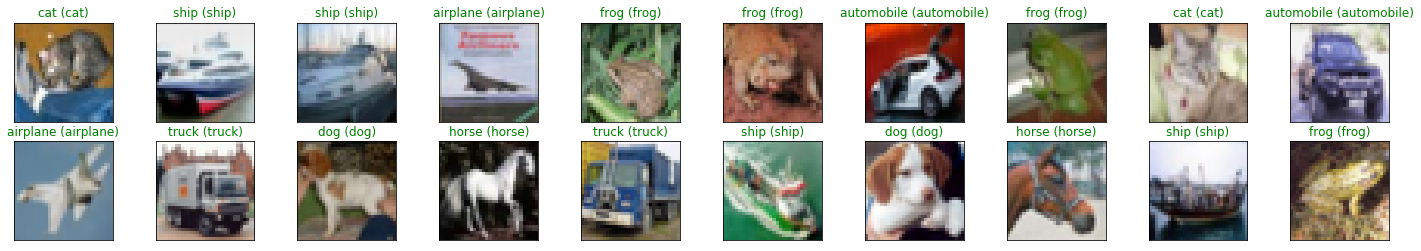

In [18]:
# Obtain one batch of test images
images, labels = next(iter(test_loader))
images.numpy()

if train_gpu:
    images = images.cuda()

# Get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))